# AI FOR FINANCE: FINAL PROJECT
## Depedri Kevin - MAT:229358
### June 2022

In [1]:
# LIBRARY IMPORT
import eikon as ek
import plotly.express as px
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [2]:
# CONNECTION TO EIKON
ek.set_app_key('4d47b9f859b94ee59a82436a7761123222ee3d07')

In [2]:
# SET PANDAS PRINT OPTIONS
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 160)
# pd.set_option('display.max_rows', None)

In [3]:
# DEFINITION OF REQUIRED FUNCTIONS
def extract_data(company_tickers, fields_to_extract, custom_fields_option, standard_options, print_info=False, save=False):
    """
    Extracts data from Refinitiv eikon (the connection to the API need to be defined in the previous steps).
    :param company_tickers: Ticker of the company (extracted from Refinitiv Workspace)
    :param fields_to_extract: Fields to extract (extracted from Refinitiv Workspace Data Item Browser, and from the Financial section of that company on Refinitiv Workspace)
    :param custom_fields_option: Extra information for fields that need a custom setup
    :param standard_options: Standard options that are applied to all the fields, excpet the one for which a custom field is defined
    :param print_info: If TRUE prints all the procedure of data extraction, concatenation and cleaning
    :param save: If TRUE save the extracted data as a csv file called 'COMPANY.TICKER_DATA.csv'
    :return: Pandas Data-frame with all the required data, concatenated according the release date, and with fixed month information for the data which are relased earlier (i.e., analysts' opinions and estimates)
    """
    df_list = []

    while len(custom_fields_option) < len(fields_to_extract):
        custom_fields_option.append({})

    for i, field in enumerate(fields_to_extract):
        extracted_field, error = ek.get_data(company_tickers, [field+'.date', field if bool(custom_fields_option[i]) == False else custom_fields_option[i]], standard_options)
        extracted_field = extracted_field.drop('Instrument', axis=1)
        for row in range(len(extracted_field)):
            date = extracted_field['Date'].iloc[row][:7]
            year = date[0:5]
            month = date[5:7]
            if month == '01' or month == '02' or month == '03': month = '03'
            else:
                if month == '04' or month == '05' or month == '06': month = '06'
                else:
                    if month == '07' or month == '08' or month == '09': month = '09'
                    else:
                        if month == '10' or month == '11' or month == '12': month = '12'
            corrected_date = year + month
            extracted_field['Date'].iloc[row] = corrected_date

        extracted_field = extracted_field.drop_duplicates('Date')
        extracted_field = extracted_field.set_index('Date')
        df_list.append(extracted_field)

        if error:
            print("ERRORS:", error)
        if print_info:
            print("Extracted data at iteration:",i)
            print(extracted_field)

    concatenated_df = pd.DataFrame()
    for i, df in enumerate(df_list):
        if i == 0:
            concatenated_df = df
            if print_info:
                print("INITIAL DF\n", concatenated_df)
        else:
            concatenated_df = concatenated_df.join(df, how='left')
            if print_info:
                print("BUILDING DF, ITERATION {}\n".format(i), concatenated_df)

    concatenated_df = concatenated_df.rename(columns={"Revenue from Business Activities - Total": "Revenue",
                                                      "Operating Profit before Non-Recurring Income/Expense" : "Operating Profit",
                                                      "Price Target - Mean": "Price Target",
                                                      "Total Shareholders' Equity incl Minority Intr & Hybrid Debt": "Shareholders Equity",
                                                      "Net Cash - Ending Balance": "Net Cash"})
    if print_info:
        print("FINAL DF\n",concatenated_df)

    if concatenated_df.index[0] > concatenated_df.index[1]:
        if print_info:
            print("FLIP APPLIED")
        concatenated_df = concatenated_df.iloc[::-1].copy()

    concatenated_df = concatenated_df.fillna(method='ffill')
    concatenated_df = concatenated_df.dropna(axis=0)
    concatenated_df = concatenated_df.drop_duplicates()
    concatenated_df = concatenated_df.astype(float)

    if save:
        concatenated_df.to_csv(company_tickers+'_DATA.csv', header=True, index=True)

    return concatenated_df
def load_data(csv_name):
    """
    Allow to load a CSV file from local, to be used if the are problems in the connection to Refinitiv Workspace, or if the notebook has been run accidentally erasing all the results
    :param csv_name: name of the csv file to be loaded
    :return: Pandas Data-frame containing all the data of the csv file
    """
    input_data = pd.read_csv(csv_name+'.csv', index_col=0, parse_dates=True)
    return input_data
def ols_regression(dependent_variable, independent_variable):
    """
    Build an OLS regression model given the dependent variable (the variable that we want to predict) and the independent variables (the predictors)
    :param dependent_variable: single variable to be tracked
    :param independent_variable: single variable or set of variables used to perform the prediction
    :return: Stats-model OLS
    """
    Y = dependent_variable
    X = independent_variable
    # Add a constant to the independent value
    X = sm.add_constant(X)
    # make regression model
    ols_model = sm.OLS(Y.astype(float), X.astype(float))  # Astype added to fix the problem, why?
    # make regression model
    results = ols_model.fit()
    return results
def remove_insignificant_ols_variables(p_values, p_value_threshold=0.05):
    """
    Given a list of p-values, and given a threshold for the p-values, returns the position of the variable with the highest p-value, to allow its removal from the model. In the case that only one variable is in list, then it returns stops=TRUE to avoid that the variable is removed since it is the last one
    :param p_values: list of p-values extracted from the model
    :param p_value_threshold: maximum p-value that can be accepted, everything above will be removed
    :return: STOP=True (if nothing to remove) or STOP=False and position_to_remove (if there is an element to remove)
    """
    max_p_value = 0
    position_to_remove = 0
    if len(p_values) > 1:
        only_one_variable_remains = False
    else:
        only_one_variable_remains = True

    for position in p_values.index:
        #print(position, " ", p_values[position])
        if p_values[position] > max_p_value and p_values[position] > p_value_threshold and not only_one_variable_remains:
            max_p_value = p_values[position]
            position_to_remove = position

    if max_p_value == 0:
        stop = True
        if not only_one_variable_remains:
            print("STOP, no more statistically insignificant terms to remove")
        else:
            print("STOP, only one variables remains and it cannot be removed")
    else:
        stop = False
        print("RESULT: {} will be removed since it has the highest p-value of {}\n\n".format(position_to_remove, max_p_value))
    return stop, position_to_remove
def mse_rmse(reference_data, in_sample_prediction, out_of_sample_prediction, rec_out_fo_sample_prediction):
    """
    Given the reference data and give the following predictions: the in_sample, out_of_sample, recursive_out_of_sample. Compute the MSE and RMSE between each prediction and the referece data
    :param reference_data: True value that we wanted to predict
    :param in_sample_prediction: value predicted ny the In-Sample model
    :param out_of_sample_prediction: value predicted ny the Out-of-Sample model
    :param rec_out_fo_sample_prediction: value predicted ny the Recursive-out-of-Sample model
    :return: print of the computed values of MSE and RMS
    """
    rmse = sm.tools.eval_measures.rmse
    mse = sm.tools.eval_measures.mse

    mse_in_sample = mse(reference_data, in_sample_prediction)
    print(f"In sample MSE: {round(mse_in_sample, 3)}")
    mse_out_of_sample = mse(reference_data, out_of_sample_prediction)
    print(f"Out of sample MSE: {round(mse_out_of_sample, 3)}")
    mse_rec_out_fo_sample = mse(reference_data, rec_out_fo_sample_prediction)
    print(f"Recurrent out of sample MSE: {round(mse_rec_out_fo_sample, 3)}\n")

    rmse_in_sample = rmse(reference_data, in_sample_prediction)
    print(f"In sample RMSE: {round(rmse_in_sample, 3)}")
    rmse_out_of_sample = rmse(reference_data, out_of_sample_prediction)
    print(f"Out of sample RMSE: {round(rmse_out_of_sample, 3)}")
    rmse_rec_out_fo_sample = rmse(reference_data, rec_out_fo_sample_prediction)
    print(f"Recurrent out of sample RMSE: {round(rmse_rec_out_fo_sample, 3)}")
def var_model(input_data, max_lags, impulse_response_period, plot_impluse=False):
    """
    Compute a VAR model give the input data, the maximum number of lags, and the length of the wanted impulse response
    :param input_data: Data used in the VAR model
    :param max_lags: maximum number of lags in which we are interested (the effective best lag will be automatically computed)
    :param impulse_response_period: length of the impulse response in which we are interested (in the case of a print)
    :param plot_impluse: if TRUE print the chart matrix of the impulse responses
    :return: print of the results of the VAR model, and eventually the plot of the chart matrix
    """
    model = VAR(input_data.astype(float))  # Astype added to fix the problem, why?
    results = model.fit(maxlags=max_lags, ic='aic')
    irf = results.irf(impulse_response_period)  # Compute the Impulse responses over 10 periods
    print("\nVAR model results based on best lag value of {} lags:".format(irf.lags))
    print(results.summary())
    if plot_impluse:
        irf.plot(orth=False)
def lstm_train(inputs, batches_size, dataset, test_starting_index, print_info=False):
    """
    Train a LSTM-RNN using Adam optimizer and MSE as loss metric
    :param inputs: number of inputs (number of precedent values that we want to use to compute a single prediction)
    :param batches_size: Size of the batches
    :param dataset: data used for the training
    :param test_starting_index: value of index of the dataset from which the training procedure ends
    :param print_info: If TRUE print all the info of the training procedure
    :return: LSTM-RNN trained
    """
    # Definition of features (different data used), n_input (periods considered for a prediction) and epochs
    features  = dataset.shape[1]
    generator = TimeseriesGenerator(dataset[:test_starting_index, :].astype(float), dataset[:test_starting_index, 0:1].astype(float), length=inputs, batch_size=batches_size)
    for batch in range(len(generator)):
        X, y = generator[batch]
        if print_info:
            print(f'{batch+inputs}: Given the inputs X: \n{X}')
            print(f'Predict the output y: {y}\n')
            # break  # To see just one iteration
    epochs = len(generator)

    # Creation of LSTM RNN model and fitting
    LSTM_model = Sequential()
    LSTM_model.add(LSTM(100, activation='relu', input_shape=(inputs, features)))
    LSTM_model.add(Dense(1))
    LSTM_model.compile(optimizer='adam', loss='mse')
    LSTM_model.summary()
    LSTM_model.fit(generator, epochs=epochs)

    # Plot of LSTM training loss
    if print_info:
        loss_per_epoch = LSTM_model.history.history['loss']
        chart = px.line(y=loss_per_epoch, x=range(len(loss_per_epoch)), title = "LSTM training loss with {} epochs".format(epochs), labels={'x':'Epochs', 'y':'Training Loss'})
        chart.show()
    return LSTM_model
def lst_predict(inputs, dataset, test_starting_index, LSTM_model, one_prediction=False):
    """
    Given an LSTM model generate predictions
    :param inputs: number of inputs (number of precedent values that we want to use to compute a single prediction)
    :param dataset: data used for the training
    :param test_starting_index: value of index of the dataset from which the testing/predicting procedure begins
    :param LSTM_model: Already trained LSTM model (using the function lstm_train() that has been previously defined)
    :param one_prediction: If TRUE generates only one prediction and then break the function
    :return: List of generated predictions
    """
    LSTM_predictions = []
    features  = dataset.shape[1]
    for i in range(len(dataset)-test_starting_index):
        batch = dataset[test_starting_index-inputs+i:test_starting_index+i]  # (only rows and column)
        batch = batch.reshape((1, inputs, features))  # correct dimensionality (we added the batch dimension)
        print("{}. Given the input batch:\n{}".format(test_starting_index+i, batch))
        prediction = LSTM_model.predict(batch.astype(float))[0][0]
        print("The forecasted value for the {}-th row is: {}".format(test_starting_index+i, prediction))
        real = dataset[test_starting_index+i, 0]
        print("The real value to be forecasted was:", real)
        print("The error on this estimation is: {} \n".format(prediction - real))
        LSTM_predictions.append(prediction)
        if one_prediction:
            break
    return LSTM_predictions

## 1.0 DATA DOWNLOAD AND CLEANING

In [5]:
# DEFINITION OF THE WANTED COMPANY AND OF ALL THE PARAMETER FOR THE DOWNLOAD (VALUES, PERIOD, CURRENCY, ....)
company_ticker = 'AZMT.MI'
field_to_extract = ['TR.PriceClose', 'TR.PriceTargetMean', 'TR.RevenueMedian', 'TR.F.TOTREVENUE', 'TR.F.OPPROFBEFNONRECURINCEXPN', 'TR.F.NETINCAFTERTAX', 'TR.F.TOTASSETS',
                    'TR.F.TOTLIAB', 'TR.F.TOTSHHOLDEQ', 'TR.F.NETCASHENDBAL']
custom_field_option = [{'TR.PriceClose' : {'params':{'Scale': 0}}}]
standard_option = {'Scale': 6, 'SDate': 0, 'EDate': -150, 'FRQ': 'Q', 'Curn': 'EUR', 'period':'FQ0'}

# DOWNLOAD OF THE REQUIRED DATA
df1 = extract_data(company_ticker, field_to_extract, custom_field_option, standard_option, False, False)
df1

,Price Close,Price Target,Revenue - Median,Revenue,Operating Profit,Net Income after Tax,Total Assets,Total Liabilities,Shareholders Equity,Net Cash
Date,,,,,,,,,,
2007-03,10.956538,11.47631,111.000,51.099,35.817,28.437,1730.804,1470.008,313.117,186.409
2007-06,12.594223,11.86975,86.000,62.219,48.541,39.279,1717.384,1441.774,326.071,149.985
2007-09,10.699938,12.72358,90.700,38.861,25.106,19.017,1706.113,1372.130,333.983,160.623
2007-12,8.782866,12.48697,72.000,44.272,25.824,19.770,1643.223,1318.365,324.858,135.725
2008-03,6.504175,10.48750,90.500,32.228,13.737,12.754,1503.595,1280.053,223.542,-65.382
...,...,...,...,...,...,...,...,...,...,...
2021-03,19.435000,21.58333,312.000,196.941,113.696,98.333,8977.366,7961.871,1015.495,1041.593
2021-06,20.480000,23.87143,245.000,199.091,114.252,130.387,9131.462,8243.485,887.977,948.231
2021-09,23.760000,25.51539,245.000,204.700,117.128,98.427,9364.657,8411.576,953.081,1015.394


In [4]:
# OPTIONAL -  LOAD DATA LOCALLY FROM CSV FILE - ONLY IF THERE ARE PROBLEMS IN THE PREVIOUS STEP
# If there are errors while connecting to Eikon, or if the script is launched without having access to Refinitiv Workspace it is possible to load the file locally, UN-COMMENT THE NEXT LINES to do so. Only the parameters present in the loaded file will be used for the next steps, independently of the steps performed above.
company_ticker = 'AZMT.MI'
df1 = load_data(company_ticker+'_DATA')
df1

,Price Close,Price Target,Revenue - Median,Revenue,Operating Profit,Net Income after Tax,Total Assets,Total Liabilities,Shareholders Equity,Net Cash
Date,,,,,,,,,,
2007-03-01,10.956538,11.47631,111.000,51.099,35.817,28.437,1730.804,1470.008,313.117,186.409
2007-06-01,12.594223,11.86975,86.000,62.219,48.541,39.279,1717.384,1441.774,326.071,149.985
2007-09-01,10.699938,12.72358,90.700,38.861,25.106,19.017,1706.113,1372.130,333.983,160.623
2007-12-01,8.782866,12.48697,72.000,44.272,25.824,19.770,1643.223,1318.365,324.858,135.725
2008-03-01,6.504175,10.48750,90.500,32.228,13.737,12.754,1503.595,1280.053,223.542,-65.382
...,...,...,...,...,...,...,...,...,...,...
2021-03-01,19.435000,21.58333,312.000,196.941,113.696,98.333,8977.366,7961.871,1015.495,1041.593
2021-06-01,20.480000,23.87143,245.000,199.091,114.252,130.387,9131.462,8243.485,887.977,948.231
2021-09-01,23.760000,25.51539,245.000,204.700,117.128,98.427,9364.657,8411.576,953.081,1015.394


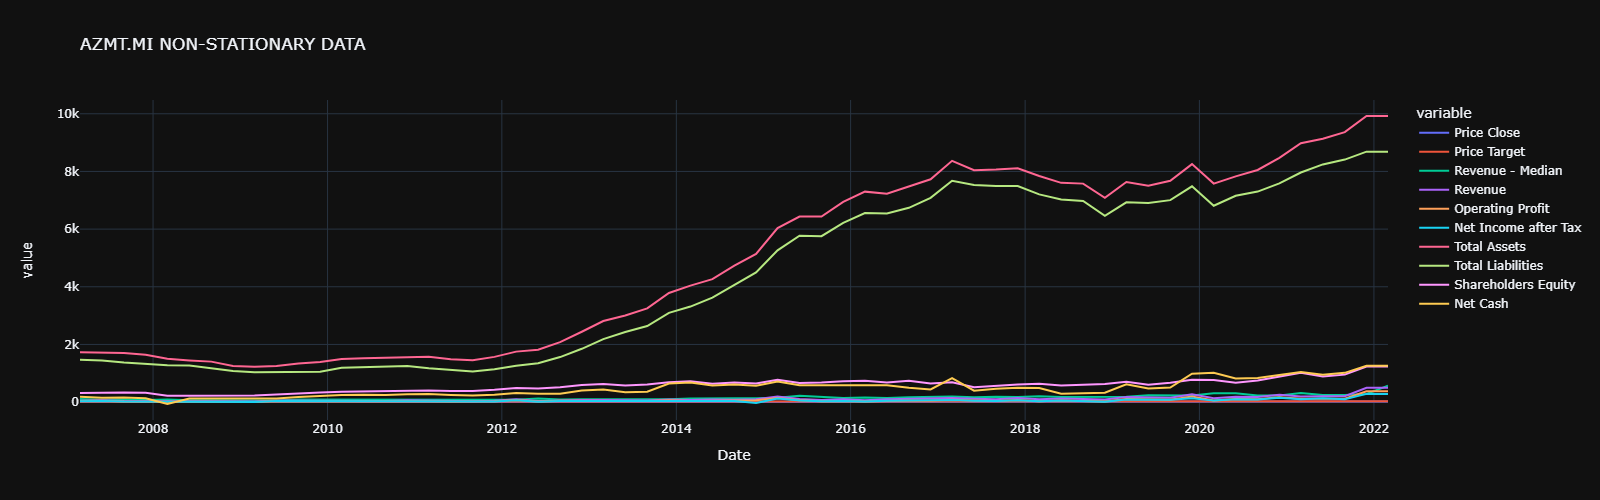

In [5]:
# PLOT OF THE EXTRACTED DATA
fig = px.line(df1, title = '{} NON-STATIONARY DATA'.format(company_ticker), template="plotly_dark", width=1600)
fig.show(renderer="png")

## 1.1 CONVERSION TO STATIONARY DATA

In [6]:
# CONVERSION TO STATIONARY DATA APPLYING THE PERCENTUAL CHANGE TO THE PREVIOUSLY EXTRACTED DATA
df2 = pd.DataFrame()
for column in df1:
    df2[column+'%'] = (df1[column].pct_change())*100
df2 = df2.dropna(axis=0).round(3)
df2 = df2.astype(float)
df2

,Price Close%,Price Target%,Revenue - Median%,Revenue%,Operating Profit%,Net Income after Tax%,Total Assets%,Total Liabilities%,Shareholders Equity%,Net Cash%
Date,,,,,,,,,,
2007-06-01,14.947,3.428,-22.523,21.762,35.525,38.126,-0.775,-1.921,4.137,-19.540
2007-09-01,-15.041,7.193,5.465,-37.542,-48.279,-51.585,-0.656,-4.830,2.426,7.093
2007-12-01,-17.917,-1.860,-20.617,13.924,2.860,3.960,-3.686,-3.918,-2.732,-15.501
2008-03-01,-25.945,-16.012,25.694,-27.205,-46.805,-35.488,-8.497,-2.906,-31.188,-148.172
2008-06-01,-14.806,-10.546,-27.403,-3.314,-5.190,-3.716,-3.819,-1.126,-0.222,-292.461
2008-09-01,-13.463,-13.011,5.023,-15.292,-32.118,-7.932,-2.886,-6.503,-0.872,-2.064
2008-12-01,-21.591,-18.096,-9.420,-20.140,-65.694,-50.106,-10.585,-8.960,-0.693,-6.509
2009-03-01,5.995,-15.432,-8.320,1.452,33.168,6.754,-2.404,-4.053,5.607,1.686
2009-06-01,67.930,34.633,-2.269,173.996,917.579,589.538,1.954,0.015,12.578,4.526


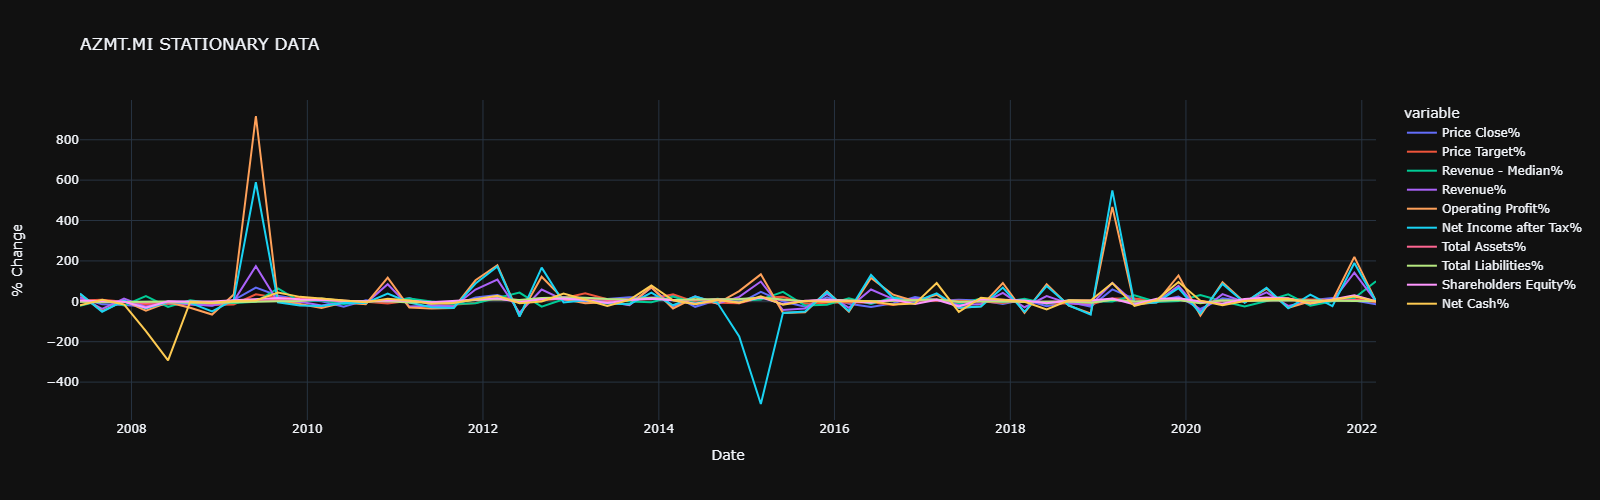

In [7]:
# PRINT OF THE COMPUTED STATIONARY DATA
fig = px.line(df2, title = '{} STATIONARY DATA'.format(company_ticker), labels={'value':'% Change'}, template="plotly_dark", width=1600)
fig.show(renderer="png")

## 2.0 VAR MODEL

In [8]:
# COMPUTATION OF A VAR MODEL TO CHECK WHICH ARE THE PARAMETERS THAT HAVE TE MOST IMPACT ON THE PRICE CHANGE OF THE STOCK
var_model(df2, 4, 10, False)


VAR model results based on best lag value of 4 lags:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Wed, 22, Feb, 2023
Time:                     10:15:48
--------------------------------------------------------------------
No. of Equations:         10.0000    BIC:                    65.3612
Nobs:                     56.0000    HQIC:                   56.2817
Log likelihood:          -1799.52    FPE:                4.93824e+23
AIC:                      50.5327    Det(Omega_mle):     2.03112e+21
--------------------------------------------------------------------
Results for equation Price Close%
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            7.169308         6.081653            1.179           0.238
L1.Price Close%                  0.126959      

c:\Users\kevin\Desktop\Stock-Price-Prediction\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning:

No frequency information was provided, so inferred frequency QS-DEC will be used.



## 3.0 OLS MODELS COMPUTATION

In [9]:
# DEFINITION OF THE NUMBER OF SAMPLES USED FOR TRAINING
number_of_samples = len(df2)
test_start_index = round(number_of_samples * 0.8)  # We will take 11 values for the out-of-sample training (from sample 0 to sample 10), but we will lose the first due to shift, so they will be 10 (observations)
number_of_test_samples = number_of_samples - test_start_index
print("Number of samples used for out-of-sample training: {} over {}. The predictions will be made over the next {} periods:".format(test_start_index, number_of_samples, number_of_test_samples))

# SEPARATION OF DEPENDENT AND INDEPENDENT VARIABLES
dependent_variables = df2['Price Close%']
independent_variables = df2
lags = 1

# CREATION OF A DATAFRAME FOR THE PREDICTED VALUES
predictions = pd.DataFrame(index=df2.index[test_start_index:], columns=["Real_Price%", "OLS_In-Sample%", "OLS_In-Sample_Sig%", "OLS_Out-of-Sample%", "OLS_Out-of-Sample_Sig%", "OLS_Recursive-Out-of-Sample%", "OLS_Recursive-Out-of-Sample_Sig%", "LSTM_In-Sample%", "LSTM_Out-of-Sample%", "LSTM_Recursive-Out-of-Sample%"]) #
predictions['Real_Price%'] = df2['Price Close%']
predictions

Number of samples used for out-of-sample training: 48 over 60. The predictions will be made over the next 12 periods:


,Real_Price%,OLS_In-Sample%,OLS_In-Sample_Sig%,OLS_Out-of-Sample%,OLS_Out-of-Sample_Sig%,OLS_Recursive-Out-of-Sample%,OLS_Recursive-Out-of-Sample_Sig%,LSTM_In-Sample%,LSTM_Out-of-Sample%,LSTM_Recursive-Out-of-Sample%
Date,,,,,,,,,,
2019-06-01,11.749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01,1.713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-01,23.577,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,-38.064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01,15.402,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,1.381,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-01,15.240,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-01,9.370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01,5.377,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.1 In-Sample OLS MODEL (NOT OPTIMIZED)

In [10]:
# COMPUTATION OF OLS IN-SAMPLE MODEL and PLOT OF RESULTS AND OBTAINED PREDICTIONS
OLS_in_sample = ols_regression(dependent_variables.iloc[lags:], independent_variables.shift(lags).iloc[lags:])
print(OLS_in_sample.summary())

for i in range(0, len(predictions.index)):
    predictions.iat[i, 1] = OLS_in_sample.predict(sm.add_constant(independent_variables).iloc[test_start_index-1+i]).values[0]
    #print("Prediction {} inputs:\n{} \nResults: {}\n".format(i, independent_variables.iloc[train_starting_index-1+i], predictions.iloc[i, 1]))

predictions

                            OLS Regression Results                            
Dep. Variable:           Price Close%   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.9343
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.511
Time:                        10:15:52   Log-Likelihood:                -258.95
No. Observations:                  59   AIC:                             539.9
Df Residuals:                      48   BIC:                             562.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.09

,Real_Price%,OLS_In-Sample%,OLS_In-Sample_Sig%,OLS_Out-of-Sample%,OLS_Out-of-Sample_Sig%,OLS_Recursive-Out-of-Sample%,OLS_Recursive-Out-of-Sample_Sig%,LSTM_In-Sample%,LSTM_Out-of-Sample%,LSTM_Recursive-Out-of-Sample%
Date,,,,,,,,,,
2019-06-01,11.749,17.99536,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01,1.713,-14.919447,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-01,23.577,4.322158,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,-38.064,5.403216,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01,15.402,-5.968736,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,1.381,8.313606,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-01,15.240,2.844068,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-01,9.370,-0.254441,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01,5.377,-3.284648,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 3.1.1 In-Sample OLS MODEL (OPTIMIZED, only statistical significant independent variables)

In [11]:
# COMPUTATION OF OLS IN-SAMPLE MODEL BASED ON STATISTICALLY SIGNIFICANT DATA
significant_independent_variables = independent_variables
OLS_in_sample_significant = 0
stop = False
while not stop:
    OLS_in_sample_significant = ols_regression(dependent_variables.iloc[lags:], significant_independent_variables.shift(lags).iloc[lags:])
    print(OLS_in_sample_significant.summary())
    p_values = OLS_in_sample_significant.pvalues[1:].round(3)
    stop, position_to_remove = remove_insignificant_ols_variables(p_values, 0.05)
    if not stop:
        significant_independent_variables = significant_independent_variables.drop(position_to_remove, axis=1)

                            OLS Regression Results                            
Dep. Variable:           Price Close%   R-squared:                       0.163
Model:                            OLS   Adj. R-squared:                 -0.011
Method:                 Least Squares   F-statistic:                    0.9343
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.511
Time:                        10:15:54   Log-Likelihood:                -258.95
No. Observations:                  59   AIC:                             539.9
Df Residuals:                      48   BIC:                             562.8
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     1.09

In [12]:
# PLOT OF THE END RESULTS AND OF THE OBTAINED PREDICTIONS FROM THE ABOVE COMPUTED MODEL
print(OLS_in_sample_significant.summary())

for i in range(0, len(predictions.index)):
    predictions.iat[i, 2] = OLS_in_sample_significant.predict(sm.add_constant(significant_independent_variables).iloc[test_start_index-1+i]).values[0]
    #print("Prediction {} inputs:\n{} \nResults: {}\n".format(i, independent_variables.iloc[train_starting_index-1+i], predictions.iloc[i, 1]))

predictions

                            OLS Regression Results                            
Dep. Variable:           Price Close%   R-squared:                       0.033
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.958
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.167
Time:                        10:15:57   Log-Likelihood:                -263.20
No. Observations:                  59   AIC:                             530.4
Df Residuals:                      57   BIC:                             534.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 2.0458      2.86

,Real_Price%,OLS_In-Sample%,OLS_In-Sample_Sig%,OLS_Out-of-Sample%,OLS_Out-of-Sample_Sig%,OLS_Recursive-Out-of-Sample%,OLS_Recursive-Out-of-Sample_Sig%,LSTM_In-Sample%,LSTM_Out-of-Sample%,LSTM_Recursive-Out-of-Sample%
Date,,,,,,,,,,
2019-06-01,11.749,17.99536,14.585677,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01,1.713,-14.919447,1.610438,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-01,23.577,4.322158,1.914863,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,-38.064,5.403216,5.482439,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01,15.402,-5.968736,0.158039,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,1.381,8.313606,4.58665,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-01,15.240,2.844068,1.874423,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-01,9.370,-0.254441,3.737763,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01,5.377,-3.284648,1.171286,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 3.2 Out-of-Sample OLS MODEL (NOT OPTIMIZED)

In [13]:
# COMPUTATION OF OLS OUT-OF-SAMPLE MODEL and PLOT OF RESULTS AND OBTAINED PREDICTIONS
OLS_out_of_sample = ols_regression(dependent_variables.iloc[lags:test_start_index], independent_variables.shift(lags).iloc[lags:test_start_index])
print(OLS_out_of_sample.summary())

for i in range(0, len(predictions.index)):
    predictions.iat[i, 3] = OLS_out_of_sample.predict(sm.add_constant(independent_variables).iloc[test_start_index-1+i]).values[0]
    #print("Prediction {} inputs:\n{} \nResults: {}\n".format(i, independent_variables.iloc[train_starting_index-1+i], predictions.iloc[i, 2]))

predictions

                            OLS Regression Results                            
Dep. Variable:           Price Close%   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     1.253
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.293
Time:                        10:15:59   Log-Likelihood:                -205.98
No. Observations:                  47   AIC:                             434.0
Df Residuals:                      36   BIC:                             454.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.29

,Real_Price%,OLS_In-Sample%,OLS_In-Sample_Sig%,OLS_Out-of-Sample%,OLS_Out-of-Sample_Sig%,OLS_Recursive-Out-of-Sample%,OLS_Recursive-Out-of-Sample_Sig%,LSTM_In-Sample%,LSTM_Out-of-Sample%,LSTM_Recursive-Out-of-Sample%
Date,,,,,,,,,,
2019-06-01,11.749,17.99536,14.585677,31.606671,NaN,NaN,NaN,NaN,NaN,NaN
2019-09-01,1.713,-14.919447,1.610438,-17.254116,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-01,23.577,4.322158,1.914863,2.110421,NaN,NaN,NaN,NaN,NaN,NaN
2020-03-01,-38.064,5.403216,5.482439,13.383961,NaN,NaN,NaN,NaN,NaN,NaN
2020-06-01,15.402,-5.968736,0.158039,-17.961397,NaN,NaN,NaN,NaN,NaN,NaN
2020-09-01,1.381,8.313606,4.58665,16.406679,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-01,15.240,2.844068,1.874423,-3.184148,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-01,9.370,-0.254441,3.737763,2.483133,NaN,NaN,NaN,NaN,NaN,NaN
2021-06-01,5.377,-3.284648,1.171286,-7.354531,NaN,NaN,NaN,NaN,NaN,NaN


#### 3.2.1 Out-of-Sample OLS MODEL (OPTIMIZED, only statistical significant independent variables)

In [14]:
# COMPUTATION OF OLS OUT-OF-SAMPLE MODEL BASED ON STATISTICALLY SIGNIFICANT DATA
significant_independent_variables = independent_variables
OLS_out_of_sample_significant = 0
stop = False
while not stop:
    OLS_out_of_sample_significant = ols_regression(dependent_variables.iloc[lags:test_start_index], significant_independent_variables.shift(lags).iloc[lags:test_start_index])
    print(OLS_out_of_sample_significant.summary())
    p_values = OLS_out_of_sample_significant.pvalues[1:].round(3)
    stop, position_to_remove = remove_insignificant_ols_variables(p_values, 0.05)
    if not stop:
        significant_independent_variables = significant_independent_variables.drop(position_to_remove, axis=1)

                            OLS Regression Results                            
Dep. Variable:           Price Close%   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     1.253
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.293
Time:                        10:16:01   Log-Likelihood:                -205.98
No. Observations:                  47   AIC:                             434.0
Df Residuals:                      36   BIC:                             454.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.29

In [15]:
# PLOT OF THE END RESULTS AND OF THE OBTAINED PREDICTIONS FROM THE ABOVE COMPUTED MODEL
print(OLS_out_of_sample_significant.summary())

for i in range(0, len(predictions.index)):
    predictions.iat[i, 4] = OLS_out_of_sample_significant.predict(sm.add_constant(significant_independent_variables).iloc[test_start_index-1+i]).values[0]
    #print("Prediction {} inputs:\n{} \nResults: {}\n".format(i, independent_variables.iloc[train_starting_index-1+i], predictions.iloc[i, 2]))

predictions

                            OLS Regression Results                            
Dep. Variable:           Price Close%   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     3.236
Date:                Wed, 22 Feb 2023   Prob (F-statistic):             0.0788
Time:                        10:16:03   Log-Likelihood:                -211.37
No. Observations:                  47   AIC:                             426.7
Df Residuals:                      45   BIC:                             430.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 1.5758      3.30

,Real_Price%,OLS_In-Sample%,OLS_In-Sample_Sig%,OLS_Out-of-Sample%,OLS_Out-of-Sample_Sig%,OLS_Recursive-Out-of-Sample%,OLS_Recursive-Out-of-Sample_Sig%,LSTM_In-Sample%,LSTM_Out-of-Sample%,LSTM_Recursive-Out-of-Sample%
Date,,,,,,,,,,
2019-06-01,11.749,17.99536,14.585677,31.606671,20.468103,NaN,NaN,NaN,NaN,NaN
2019-09-01,1.713,-14.919447,1.610438,-17.254116,0.919927,NaN,NaN,NaN,NaN,NaN
2019-12-01,23.577,4.322158,1.914863,2.110421,1.378565,NaN,NaN,NaN,NaN,NaN
2020-03-01,-38.064,5.403216,5.482439,13.383961,6.753387,NaN,NaN,NaN,NaN,NaN
2020-06-01,15.402,-5.968736,0.158039,-17.961397,-1.268222,NaN,NaN,NaN,NaN,NaN
2020-09-01,1.381,8.313606,4.58665,16.406679,5.403814,NaN,NaN,NaN,NaN,NaN
2020-12-01,15.240,2.844068,1.874423,-3.184148,1.31764,NaN,NaN,NaN,NaN,NaN
2021-03-01,9.370,-0.254441,3.737763,2.483133,4.124902,NaN,NaN,NaN,NaN,NaN
2021-06-01,5.377,-3.284648,1.171286,-7.354531,0.258311,NaN,NaN,NaN,NaN,NaN


### 3.3 Recursive-Out-of-Sample OLS MODEL (NOT OPTIMIZED)

In [16]:
# COMPUTATION OF OLS RECURSIVE-OUT-OF-SAMPLE MODEL and PLOT OF RESULTS AND OBTAINED PREDICTIONS
recursive_r2 = []
iteration = 1
for i in range(0, len(predictions.index)):
    print("\n\n----------------------------- ITERATION NUMBER {} -----------------------------".format(iteration))
    rec_OLS_out_of_sample = ols_regression(dependent_variables.iloc[lags:test_start_index+i], independent_variables.shift(lags).iloc[lags:test_start_index+i])
    print(rec_OLS_out_of_sample.summary())
    predictions.iat[i, 5] = rec_OLS_out_of_sample.predict(sm.add_constant(independent_variables).iloc[test_start_index-1+i]).values[0]
    #print("Prediction {} inputs:\n{} \nResults: {}\n".format(i, independent_variables.iloc[train_starting_index-1+i], predictions.iloc[i, 3]))
    recursive_r2.append(round(rec_OLS_out_of_sample.rsquared, 3))
    iteration += 1

# LATEST RUN (out of the cycle since we are not interested into generating a prediction for which we still don't have the real value to evaluate the prediction godness.
print("\n\n----------------------------- ITERATION NUMBER {} -----------------------------".format(iteration))
rec_OLS_out_of_sample = ols_regression(dependent_variables.iloc[lags:test_start_index+i+1], independent_variables.shift(lags).iloc[lags:test_start_index+i+1])
print(rec_OLS_out_of_sample.summary())
recursive_r2.append(round(rec_OLS_out_of_sample.rsquared, 3))
print("\nThe evolution of R-squared for the {} iterations is:\n {}\n".format(len(predictions.index)+1, recursive_r2))

predictions = predictions.round(3)
predictions



----------------------------- ITERATION NUMBER 1 -----------------------------
                            OLS Regression Results                            
Dep. Variable:           Price Close%   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     1.253
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.293
Time:                        10:16:05   Log-Likelihood:                -205.98
No. Observations:                  47   AIC:                             434.0
Df Residuals:                      36   BIC:                             454.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

,Real_Price%,OLS_In-Sample%,OLS_In-Sample_Sig%,OLS_Out-of-Sample%,OLS_Out-of-Sample_Sig%,OLS_Recursive-Out-of-Sample%,OLS_Recursive-Out-of-Sample_Sig%,LSTM_In-Sample%,LSTM_Out-of-Sample%,LSTM_Recursive-Out-of-Sample%
Date,,,,,,,,,,
2019-06-01,11.749,17.99536,14.585677,31.606671,20.468103,31.606671,NaN,NaN,NaN,NaN
2019-09-01,1.713,-14.919447,1.610438,-17.254116,0.919927,-17.507407,NaN,NaN,NaN,NaN
2019-12-01,23.577,4.322158,1.914863,2.110421,1.378565,1.289806,NaN,NaN,NaN,NaN
2020-03-01,-38.064,5.403216,5.482439,13.383961,6.753387,13.215737,NaN,NaN,NaN,NaN
2020-06-01,15.402,-5.968736,0.158039,-17.961397,-1.268222,-14.20475,NaN,NaN,NaN,NaN
2020-09-01,1.381,8.313606,4.58665,16.406679,5.403814,9.754506,NaN,NaN,NaN,NaN
2020-12-01,15.240,2.844068,1.874423,-3.184148,1.31764,-1.605106,NaN,NaN,NaN,NaN
2021-03-01,9.370,-0.254441,3.737763,2.483133,4.124902,0.111054,NaN,NaN,NaN,NaN
2021-06-01,5.377,-3.284648,1.171286,-7.354531,0.258311,-2.338557,NaN,NaN,NaN,NaN


#### 3.3.1 Recursive-Out-of-Sample OLS MODEL (OPTIMIZED, only statistical significant independent variables)

In [17]:
# COMPUTATION OF OLS RECURSIVE-OUT-OF-SAMPLE MODEL BASED ON STATISTICALLY SIGNIFICANT DATA and PLOT OF RESULTS AND OBTAINED PREDICTIONS
recursive_r2_significant = []
iteration = 1
for i in range(0, len(predictions.index)):
    significant_independent_variables = independent_variables
    rec_OLS_out_of_sample_significant = 0
    print("\n\n----------------------------- ITERATION NUMBER {} -----------------------------".format(iteration))
    stop = False
    while not stop:
        rec_OLS_out_of_sample_significant = ols_regression(dependent_variables.iloc[lags:test_start_index+i], significant_independent_variables.shift(lags).iloc[lags:test_start_index+i])
        print(rec_OLS_out_of_sample_significant.summary())
        p_values = rec_OLS_out_of_sample_significant.pvalues[1:].round(3)
        stop, position_to_remove = remove_insignificant_ols_variables(p_values, 0.05)
        if not stop:
            significant_independent_variables = significant_independent_variables.drop(position_to_remove, axis=1)

    predictions.iat[i, 6] = rec_OLS_out_of_sample_significant.predict(sm.add_constant(significant_independent_variables).iloc[test_start_index-1+i]).values[0]
    recursive_r2_significant.append(round(rec_OLS_out_of_sample_significant.rsquared, 3))
    iteration += 1

# LATEST RUN (out of the cycle since we are not interested into generating a prediction for which we still don't have the real value to evaluate the prediction godness.
significant_independent_variables = independent_variables
rec_OLS_out_of_sample_significant = 0
print("\n\n----------------------------- ITERATION NUMBER {} -----------------------------".format(iteration))
stop = False
while not stop:
    rec_OLS_out_of_sample_significant = ols_regression(dependent_variables.iloc[lags:test_start_index+i+1], significant_independent_variables.shift(lags).iloc[lags:test_start_index+i+1])
    print(rec_OLS_out_of_sample_significant.summary())
    p_values = rec_OLS_out_of_sample_significant.pvalues[1:].round(3)
    stop, position_to_remove = remove_insignificant_ols_variables(p_values, 0.05)
    if not stop:
        significant_independent_variables = significant_independent_variables.drop(position_to_remove, axis=1)
recursive_r2_significant.append(round(rec_OLS_out_of_sample_significant.rsquared, 3))
print("\nThe evolution of R-squared for the {} iterations is:\n {}\n".format(len(predictions.index)+1, recursive_r2_significant))

predictions = predictions.round(3)
predictions



----------------------------- ITERATION NUMBER 1 -----------------------------
                            OLS Regression Results                            
Dep. Variable:           Price Close%   R-squared:                       0.258
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     1.253
Date:                Wed, 22 Feb 2023   Prob (F-statistic):              0.293
Time:                        10:16:08   Log-Likelihood:                -205.98
No. Observations:                  47   AIC:                             434.0
Df Residuals:                      36   BIC:                             454.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------

,Real_Price%,OLS_In-Sample%,OLS_In-Sample_Sig%,OLS_Out-of-Sample%,OLS_Out-of-Sample_Sig%,OLS_Recursive-Out-of-Sample%,OLS_Recursive-Out-of-Sample_Sig%,LSTM_In-Sample%,LSTM_Out-of-Sample%,LSTM_Recursive-Out-of-Sample%
Date,,,,,,,,,,
2019-06-01,11.749,17.99536,14.585677,31.606671,20.468103,31.606671,20.468103,NaN,NaN,NaN
2019-09-01,1.713,-14.919447,1.610438,-17.254116,0.919927,-17.507407,-15.17535,NaN,NaN,NaN
2019-12-01,23.577,4.322158,1.914863,2.110421,1.378565,1.289806,1.351007,NaN,NaN,NaN
2020-03-01,-38.064,5.403216,5.482439,13.383961,6.753387,13.215737,6.666419,NaN,NaN,NaN
2020-06-01,15.402,-5.968736,0.158039,-17.961397,-1.268222,-14.20475,-1.062559,NaN,NaN,NaN
2020-09-01,1.381,8.313606,4.58665,16.406679,5.403814,9.754506,4.606015,NaN,NaN,NaN
2020-12-01,15.240,2.844068,1.874423,-3.184148,1.31764,-1.605106,1.368834,NaN,NaN,NaN
2021-03-01,9.370,-0.254441,3.737763,2.483133,4.124902,0.111054,3.78818,NaN,NaN,NaN
2021-06-01,5.377,-3.284648,1.171286,-7.354531,0.258311,-2.338557,0.930727,NaN,NaN,NaN


### 3.4 PLOT OF OLS PREDICTIONS

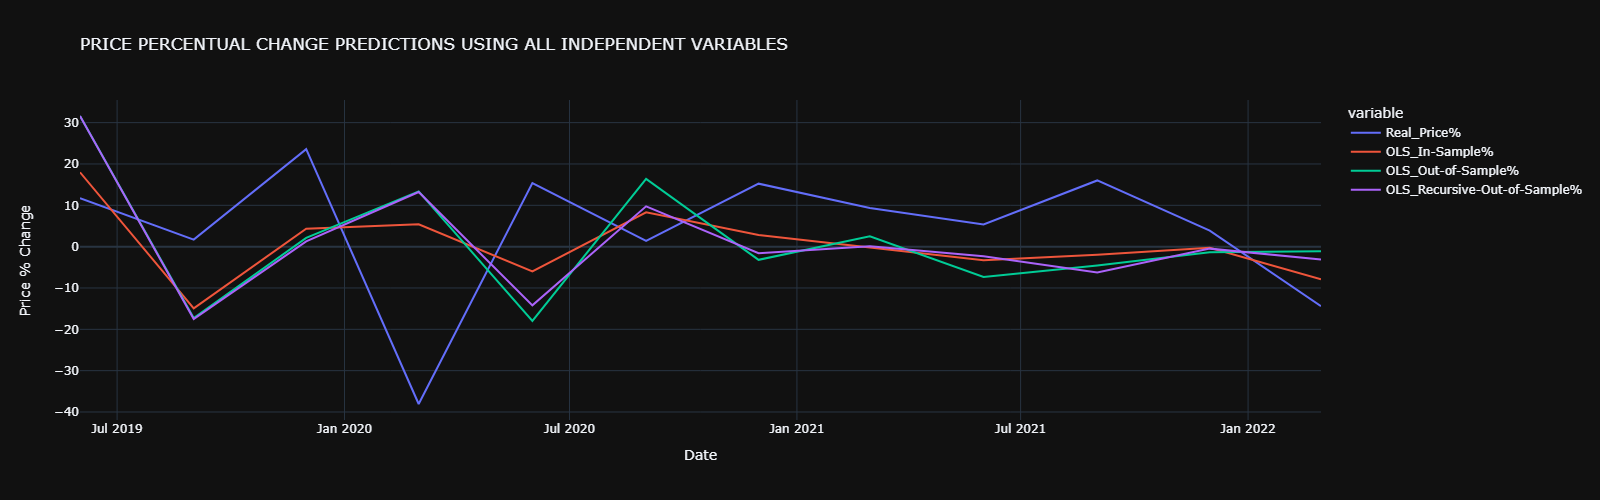

In [18]:
# PLOT OF ALL THE PREDICTIONS OBTAINED BY THE OLS MODELS (BASED ON ALL THE INDEPENDENT VARIABLES)
predictions = predictions.astype(float)
fig = px.line(predictions, y=["Real_Price%", "OLS_In-Sample%", "OLS_Out-of-Sample%", "OLS_Recursive-Out-of-Sample%"],
              title = 'PRICE PERCENTUAL CHANGE PREDICTIONS USING ALL INDEPENDENT VARIABLES',
              labels={'value':'Price % Change', 'index':'Period'}, template="plotly_dark", width=1600)
fig.show(renderer="png")

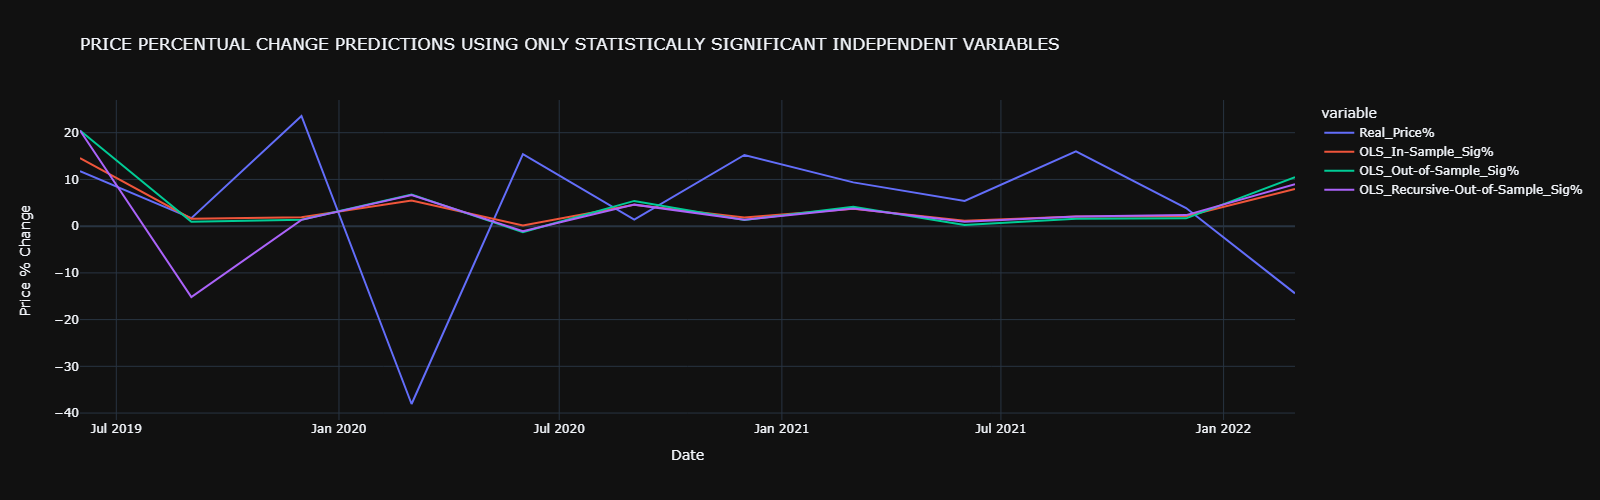

In [19]:
# PLOT OF ALL THE PREDICTIONS OBTAINED BY THE OLS MODELS (BASED ONLY ON THE STATISTICALLY SIGNIFICANT INDEPENDENT VARIABLES)
fig = px.line(predictions, y=["Real_Price%", "OLS_In-Sample_Sig%", "OLS_Out-of-Sample_Sig%", "OLS_Recursive-Out-of-Sample_Sig%"],
              title = 'PRICE PERCENTUAL CHANGE PREDICTIONS USING ONLY STATISTICALLY SIGNIFICANT INDEPENDENT VARIABLES',
              labels={'value':'Price % Change', 'index':'Period'}, template="plotly_dark", width=1600)
fig.show(renderer="png")

### 3.5 MSEs OF OLS PREDICTIONS

In [20]:
# COMPUTATION OF MSEs and RMSEs FOR ALL THE PREDICTIONS OBTAINED BY THE OLS MODELS (BASED ON ALL THE INDEPENDENT VARIABLES)
print("Metrics with all variables:\n")
mse_rmse(predictions['Real_Price%'], predictions['OLS_In-Sample%'], predictions['OLS_Out-of-Sample%'], predictions['OLS_Recursive-Out-of-Sample%'])

Metrics with all variables:

In sample MSE: 315.393
Out of sample MSE: 531.241
Recurrent out of sample MSE: 492.241

In sample RMSE: 17.759
Out of sample RMSE: 23.049
Recurrent out of sample RMSE: 22.187


In [21]:
# COMPUTATION OF MSEs and RMSEs FOR ALL THE PREDICTIONS OBTAINED BY THE OLS MODELS (BASED ONLY ON THE STATISTICALLY SIGNIFICANT INDEPENDENT VARIABLES)
print("Metrics with selected variables:\n")
mse_rmse(predictions['Real_Price%'], predictions['OLS_In-Sample_Sig%'], predictions['OLS_Out-of-Sample_Sig%'], predictions['OLS_Recursive-Out-of-Sample_Sig%'])

Metrics with selected variables:

In sample MSE: 295.051
Out of sample MSE: 329.126
Recurrent out of sample MSE: 343.645

In sample RMSE: 17.177
Out of sample RMSE: 18.142
Recurrent out of sample RMSE: 18.538


## 4.0 RECURRENT NEURAL NETWORK (RNN) LONG-SHORT-TERM-MEMORY(LSTM)

### 4.1 Seasonality Analysis

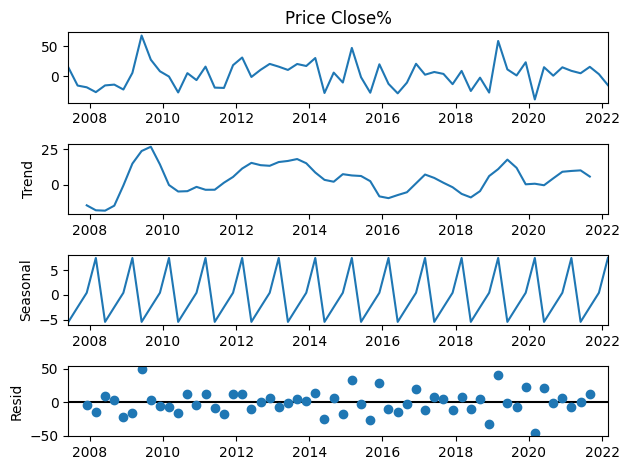

In [22]:
# SEASONALITY ANALYSIS TO CHECK IF THERE ARE SEASONALITY PATTERNS IN THE INPUT DATA THAT THE RNN WILL BE ABLE TO EXTRACT
seasonality_results = seasonal_decompose(df2['Price Close%'], period=4)
seasonality_results.plot()
print(end='')

In [23]:
# CONVERSION TO NUMPY MATRIX TO WORK BETTER INTO LSTMs TRAINING LOOPs
train_np = df2.astype(float).to_numpy()
header = ""
for column in df2:
    header = header + column + "  "
print("Each sub-array is composed of the following data:\n", header)
train_np

Each sub-array is composed of the following data:
 Price Close%  Price Target%  Revenue - Median%  Revenue%  Operating Profit%  Net Income after Tax%  Total Assets%  Total Liabilities%  Shareholders Equity%  Net Cash%  


array([[ 1.49470e+01,  3.42800e+00, -2.25230e+01,  2.17620e+01,
         3.55250e+01,  3.81260e+01, -7.75000e-01, -1.92100e+00,
         4.13700e+00, -1.95400e+01],
       [-1.50410e+01,  7.19300e+00,  5.46500e+00, -3.75420e+01,
        -4.82790e+01, -5.15850e+01, -6.56000e-01, -4.83000e+00,
         2.42600e+00,  7.09300e+00],
       [-1.79170e+01, -1.86000e+00, -2.06170e+01,  1.39240e+01,
         2.86000e+00,  3.96000e+00, -3.68600e+00, -3.91800e+00,
        -2.73200e+00, -1.55010e+01],
       [-2.59450e+01, -1.60120e+01,  2.56940e+01, -2.72050e+01,
        -4.68050e+01, -3.54880e+01, -8.49700e+00, -2.90600e+00,
        -3.11880e+01, -1.48172e+02],
       [-1.48060e+01, -1.05460e+01, -2.74030e+01, -3.31400e+00,
        -5.19000e+00, -3.71600e+00, -3.81900e+00, -1.12600e+00,
        -2.22000e-01, -2.92461e+02],
       [-1.34630e+01, -1.30110e+01,  5.02300e+00, -1.52920e+01,
        -3.21180e+01, -7.93200e+00, -2.88600e+00, -6.50300e+00,
        -8.72000e-01, -2.06400e+00],
       [-2

In [24]:
# DEFINITION OF THE NUMBER OF INPUTS (PERIODS USED TO PREDICT THE NEXT PERIOD) AND ON THE BATCH SIZE (HOW MANY PERIODS WE DO HAVE IN ONE BATCH)
n_input = 4
batch_size = 1

### 4.2 In-Sample LSTM MODEL

In [25]:
# TRAINING OF LSTM IN-SAMPLE MODEL and PLOT OF RESULTS AND OBTAINED PREDICTIONS
LSTM_in_sample = lstm_train(n_input, batch_size, train_np, len(train_np), True)
predictions['LSTM_In-Sample%'] = lst_predict(n_input, train_np, test_start_index, LSTM_in_sample)
predictions = predictions.round(3)
predictions

4: Given the inputs X: 
[[[  14.947    3.428  -22.523   21.762   35.525   38.126   -0.775
     -1.921    4.137  -19.54 ]
  [ -15.041    7.193    5.465  -37.542  -48.279  -51.585   -0.656
     -4.83     2.426    7.093]
  [ -17.917   -1.86   -20.617   13.924    2.86     3.96    -3.686
     -3.918   -2.732  -15.501]
  [ -25.945  -16.012   25.694  -27.205  -46.805  -35.488   -8.497
     -2.906  -31.188 -148.172]]]
Predict the output y: [[-14.806]]

5: Given the inputs X: 
[[[-1.50410e+01  7.19300e+00  5.46500e+00 -3.75420e+01 -4.82790e+01
   -5.15850e+01 -6.56000e-01 -4.83000e+00  2.42600e+00  7.09300e+00]
  [-1.79170e+01 -1.86000e+00 -2.06170e+01  1.39240e+01  2.86000e+00
    3.96000e+00 -3.68600e+00 -3.91800e+00 -2.73200e+00 -1.55010e+01]
  [-2.59450e+01 -1.60120e+01  2.56940e+01 -2.72050e+01 -4.68050e+01
   -3.54880e+01 -8.49700e+00 -2.90600e+00 -3.11880e+01 -1.48172e+02]
  [-1.48060e+01 -1.05460e+01 -2.74030e+01 -3.31400e+00 -5.19000e+00
   -3.71600e+00 -3.81900e+00 -1.12600e+00 -2.220

48. Given the input batch:
[[[-2.40180e+01 -1.08830e+01 -1.17910e+01  2.61680e+01  8.43130e+01
    7.52730e+01 -3.02700e+00 -2.47900e+00 -9.20700e+00 -3.99970e+01]
  [-1.92400e+00 -9.05000e+00  5.07600e+00 -1.01360e+01 -2.17240e+01
   -1.95960e+01 -3.51000e-01 -7.01000e-01  3.89200e+00  5.43600e+00]
  [-2.66620e+01 -1.59900e+01 -1.50300e+00 -1.83120e+01 -5.98830e+01
   -6.59600e+01 -6.48900e+00 -7.37000e+00  3.72000e+00  4.43900e+00]
  [ 5.89050e+01  1.34540e+01 -4.09000e-01  9.08840e+01  4.67614e+02
    5.49362e+02  7.75700e+00  7.21900e+00  1.33310e+01  9.06380e+01]]]
1/1 [==============================] - 0s 133ms/step
The forecasted value for the 48-th row is: 12.382669448852539
The real value to be forecasted was: 11.749
The error on this estimation is: 0.6336694488525385 

49. Given the input batch:
[[[-1.92400e+00 -9.05000e+00  5.07600e+00 -1.01360e+01 -2.17240e+01
   -1.95960e+01 -3.51000e-01 -7.01000e-01  3.89200e+00  5.43600e+00]
  [-2.66620e+01 -1.59900e+01 -1.50300e+00 -1.8

,Real_Price%,OLS_In-Sample%,OLS_In-Sample_Sig%,OLS_Out-of-Sample%,OLS_Out-of-Sample_Sig%,OLS_Recursive-Out-of-Sample%,OLS_Recursive-Out-of-Sample_Sig%,LSTM_In-Sample%,LSTM_Out-of-Sample%,LSTM_Recursive-Out-of-Sample%
Date,,,,,,,,,,
2019-06-01,11.749,17.995,14.586,31.607,20.468,31.607,20.468,12.383000,NaN,NaN
2019-09-01,1.713,-14.919,1.610,-17.254,0.920,-17.507,-15.175,2.446000,NaN,NaN
2019-12-01,23.577,4.322,1.915,2.110,1.379,1.290,1.351,23.757999,NaN,NaN
2020-03-01,-38.064,5.403,5.482,13.384,6.753,13.216,6.666,-35.612000,NaN,NaN
2020-06-01,15.402,-5.969,0.158,-17.961,-1.268,-14.205,-1.063,14.724000,NaN,NaN
2020-09-01,1.381,8.314,4.587,16.407,5.404,9.755,4.606,0.844000,NaN,NaN
2020-12-01,15.240,2.844,1.874,-3.184,1.318,-1.605,1.369,14.035000,NaN,NaN
2021-03-01,9.370,-0.254,3.738,2.483,4.125,0.111,3.788,9.689000,NaN,NaN
2021-06-01,5.377,-3.285,1.171,-7.355,0.258,-2.339,0.931,5.097000,NaN,NaN


### 4.3 Out-of-Sample LSTM MODEL

In [28]:
# TRAINING OF LSTM OUT-OF-SAMPLE MODEL and PLOT OF RESULTS AND OBTAINED PREDICTIONS
LSTM_out_of_sample = lstm_train(n_input, batch_size, train_np, test_start_index, True)
predictions['LSTM_Out-of-Sample%'] = lst_predict(n_input, train_np, test_start_index, LSTM_out_of_sample)
predictions = predictions.round(3)
predictions

4: Given the inputs X: 
[[[  14.947    3.428  -22.523   21.762   35.525   38.126   -0.775
     -1.921    4.137  -19.54 ]
  [ -15.041    7.193    5.465  -37.542  -48.279  -51.585   -0.656
     -4.83     2.426    7.093]
  [ -17.917   -1.86   -20.617   13.924    2.86     3.96    -3.686
     -3.918   -2.732  -15.501]
  [ -25.945  -16.012   25.694  -27.205  -46.805  -35.488   -8.497
     -2.906  -31.188 -148.172]]]
Predict the output y: [[-14.806]]

5: Given the inputs X: 
[[[-1.50410e+01  7.19300e+00  5.46500e+00 -3.75420e+01 -4.82790e+01
   -5.15850e+01 -6.56000e-01 -4.83000e+00  2.42600e+00  7.09300e+00]
  [-1.79170e+01 -1.86000e+00 -2.06170e+01  1.39240e+01  2.86000e+00
    3.96000e+00 -3.68600e+00 -3.91800e+00 -2.73200e+00 -1.55010e+01]
  [-2.59450e+01 -1.60120e+01  2.56940e+01 -2.72050e+01 -4.68050e+01
   -3.54880e+01 -8.49700e+00 -2.90600e+00 -3.11880e+01 -1.48172e+02]
  [-1.48060e+01 -1.05460e+01 -2.74030e+01 -3.31400e+00 -5.19000e+00
   -3.71600e+00 -3.81900e+00 -1.12600e+00 -2.220

48. Given the input batch:
[[[-2.40180e+01 -1.08830e+01 -1.17910e+01  2.61680e+01  8.43130e+01
    7.52730e+01 -3.02700e+00 -2.47900e+00 -9.20700e+00 -3.99970e+01]
  [-1.92400e+00 -9.05000e+00  5.07600e+00 -1.01360e+01 -2.17240e+01
   -1.95960e+01 -3.51000e-01 -7.01000e-01  3.89200e+00  5.43600e+00]
  [-2.66620e+01 -1.59900e+01 -1.50300e+00 -1.83120e+01 -5.98830e+01
   -6.59600e+01 -6.48900e+00 -7.37000e+00  3.72000e+00  4.43900e+00]
  [ 5.89050e+01  1.34540e+01 -4.09000e-01  9.08840e+01  4.67614e+02
    5.49362e+02  7.75700e+00  7.21900e+00  1.33310e+01  9.06380e+01]]]
The forecasted value for the 48-th row is: 23.643604278564453
The real value to be forecasted was: 11.749
The error on this estimation is: 11.894604278564453 

49. Given the input batch:
[[[-1.92400e+00 -9.05000e+00  5.07600e+00 -1.01360e+01 -2.17240e+01
   -1.95960e+01 -3.51000e-01 -7.01000e-01  3.89200e+00  5.43600e+00]
  [-2.66620e+01 -1.59900e+01 -1.50300e+00 -1.83120e+01 -5.98830e+01
   -6.59600e+01 -6.48900e+00 -7

,Real_Price%,OLS_In-Sample%,OLS_In-Sample_Sig%,OLS_Out-of-Sample%,OLS_Out-of-Sample_Sig%,OLS_Recursive-Out-of-Sample%,OLS_Recursive-Out-of-Sample_Sig%,LSTM_In-Sample%,LSTM_Out-of-Sample%,LSTM_Recursive-Out-of-Sample%
Date,,,,,,,,,,
2019-06,11.749,17.995,14.586,31.607,20.468,31.607,20.468,11.393000,23.643999,NaN
2019-09,1.713,-14.919,1.610,-17.254,0.920,-17.507,-15.175,0.774000,19.247999,NaN
2019-12,23.577,4.322,1.915,2.110,1.379,1.290,1.351,24.240999,10.668000,NaN
2020-03,-38.064,5.403,5.482,13.384,6.753,13.216,6.666,-37.201000,23.657000,NaN
2020-06,15.402,-5.969,0.158,-17.961,-1.268,-14.205,-1.063,13.107000,-13.216000,NaN
2020-09,1.381,8.314,4.587,16.407,5.404,9.755,4.606,2.099000,4.827000,NaN
2020-12,15.240,2.844,1.874,-3.184,1.318,-1.605,1.369,13.664000,-8.643000,NaN
2021-03,9.370,-0.254,3.738,2.483,4.125,0.111,3.788,10.675000,3.772000,NaN
2021-06,5.377,-3.285,1.171,-7.355,0.258,-2.339,0.931,5.250000,-0.982000,NaN


### 4.4 Recursive-Out-of-Sample LSTM MODEL

In [29]:
# TRAINING OF LSTM RECURRENT-OUT-OF-SAMPLE MODEL and PLOT OF RESULTS AND OBTAINED PREDICTIONS
rec_LSTM_out_of_sample_predictions = []
for i in range(len(train_np)-test_start_index):
    print("\n--------------------------ITERATION N{} :--------------------------".format(i))
    rec_LSTM_out_of_sample = lstm_train(n_input, batch_size, train_np, test_start_index+i, True if i == len(train_np)-test_start_index-1 else False)
    prediction = lst_predict(n_input, train_np, test_start_index+i, rec_LSTM_out_of_sample, True)
    rec_LSTM_out_of_sample_predictions.append(prediction[0])
predictions['LSTM_Recursive-Out-of-Sample%'] = rec_LSTM_out_of_sample_predictions
predictions = predictions.round(3)
predictions


--------------------------ITERATION N0 :--------------------------
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               44400     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 44,501
Trainable params: 44,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/44
44/44 [==============================] - 1s 1ms/step - loss: 641.0754
Epoch 2/44
44/44 [==============================] - 0s 1ms/step - loss: 365.0930
Epoch 3/44
44/44 [==============================] - 0s 1ms/step - loss: 211.2539
Epoch 4/44
44/44 [==============================] - 0s 1ms/step - loss: 113.5468
Epoch 5/44
44/44 [==============================] - 0s

2022-06-09 19:49:36,961 P[23988] [MainThread 20212] 5 out of the last 16 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001C564E79940> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


The forecasted value for the 51-th row is: 20.155868530273438
The real value to be forecasted was: -38.064
The error on this estimation is: 58.21986853027344 


--------------------------ITERATION N4 :--------------------------
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 100)               44400     
                                                                 
 dense_6 (Dense)             (None, 1)                 101       
                                                                 
Total params: 44,501
Trainable params: 44,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/48
48/48 [==============================] - 1s 2ms/step - loss: 694.9418
Epoch 2/48
48/48 [==============================] - 0s 1ms/step - loss: 400.6951
Epoch 3/48
48/48 [==============================] - 0s 1

2022-06-09 19:49:41,602 P[23988] [MainThread 20212] 6 out of the last 17 calls to <function Model.make_predict_function.<locals>.predict_function at 0x000001C56B59DEE0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


The forecasted value for the 52-th row is: -21.574914932250977
The real value to be forecasted was: 15.402
The error on this estimation is: -36.97691493225098 


--------------------------ITERATION N5 :--------------------------
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 100)               44400     
                                                                 
 dense_7 (Dense)             (None, 1)                 101       
                                                                 
Total params: 44,501
Trainable params: 44,501
Non-trainable params: 0
_________________________________________________________________
Epoch 1/49
49/49 [==============================] - 1s 1ms/step - loss: 554.0865
Epoch 2/49
49/49 [==============================] - 0s 1ms/step - loss: 468.8130
Epoch 3/49
49/49 [==============================] - 0s 

59. Given the input batch:
[[[  9.37   11.831  34.483 -22.656 -32.609 -34.504   5.946   4.935
    14.608  12.347]
  [  5.377  10.601 -21.474   1.092   0.489  32.597   1.716   3.537
   -12.557  -8.963]
  [ 16.016   6.887   0.      2.817   2.517 -24.512   2.554   2.039
     7.332   7.083]
  [  3.872  11.185  16.327 142.378 219.84  189.487   5.957   3.273
    29.641  24.239]]]
The forecasted value for the 59-th row is: 14.6792573928833
The real value to be forecasted was: -14.384
The error on this estimation is: 29.0632573928833 



,Real_Price%,OLS_In-Sample%,OLS_In-Sample_Sig%,OLS_Out-of-Sample%,OLS_Out-of-Sample_Sig%,OLS_Recursive-Out-of-Sample%,OLS_Recursive-Out-of-Sample_Sig%,LSTM_In-Sample%,LSTM_Out-of-Sample%,LSTM_Recursive-Out-of-Sample%
Date,,,,,,,,,,
2019-06,11.749,17.995,14.586,31.607,20.468,31.607,20.468,11.393000,23.643999,30.264999
2019-09,1.713,-14.919,1.610,-17.254,0.920,-17.507,-15.175,0.774000,19.247999,34.730999
2019-12,23.577,4.322,1.915,2.110,1.379,1.290,1.351,24.240999,10.668000,22.391001
2020-03,-38.064,5.403,5.482,13.384,6.753,13.216,6.666,-37.201000,23.657000,20.156000
2020-06,15.402,-5.969,0.158,-17.961,-1.268,-14.205,-1.063,13.107000,-13.216000,-21.575001
2020-09,1.381,8.314,4.587,16.407,5.404,9.755,4.606,2.099000,4.827000,-0.796000
2020-12,15.240,2.844,1.874,-3.184,1.318,-1.605,1.369,13.664000,-8.643000,-1.823000
2021-03,9.370,-0.254,3.738,2.483,4.125,0.111,3.788,10.675000,3.772000,6.125000
2021-06,5.377,-3.285,1.171,-7.355,0.258,-2.339,0.931,5.250000,-0.982000,-1.363000


In [30]:
# EXTRACTION OF THE LSTM PREDICTIONS FROM THE PREVIOUS DATAFRAME TO LOOK AT THEM MORE IN DETAIL
lstm_predictions = predictions.drop(['OLS_In-Sample%', 'OLS_In-Sample_Sig%', 'OLS_Out-of-Sample%', 'OLS_Out-of-Sample_Sig%', 'OLS_Recursive-Out-of-Sample%', 'OLS_Recursive-Out-of-Sample_Sig%'], axis=1)
lstm_predictions

,Real_Price%,LSTM_In-Sample%,LSTM_Out-of-Sample%,LSTM_Recursive-Out-of-Sample%
Date,,,,
2019-06,11.749,11.393000,23.643999,30.264999
2019-09,1.713,0.774000,19.247999,34.730999
2019-12,23.577,24.240999,10.668000,22.391001
2020-03,-38.064,-37.201000,23.657000,20.156000
2020-06,15.402,13.107000,-13.216000,-21.575001
2020-09,1.381,2.099000,4.827000,-0.796000
2020-12,15.240,13.664000,-8.643000,-1.823000
2021-03,9.370,10.675000,3.772000,6.125000
2021-06,5.377,5.250000,-0.982000,-1.363000


### 4.5 PLOT OF LSTMs PREDICTIONS

In [31]:
# PLOT OF ALL THE PREDICTIONS OBTAINED BY THE LSTM MODELS (BASED ONLY ON ALL THE INDEPENDENT VARIABLES)
predictions = predictions.astype(float)
fig = px.line(predictions, y=["Real_Price%", "LSTM_In-Sample%", "LSTM_Out-of-Sample%", "LSTM_Recursive-Out-of-Sample%"], title = 'PRICE PERCENTUAL CHANGE PREDICTIONS',
              labels={'value':'Price % Change'})
fig.show()

### 4.6 MSEs OF LSTMs PREDICTIONS

In [32]:
# COMPUTATION OF MSEs and RMSEs FOR ALL THE PREDICTIONS OBTAINED BY THE LSTM MODELS (BASED ON ALL TGE INDEPENDENT VARIABLES)
print("Metrics with all variables (LSTM-RNN):\n")
mse_rmse(predictions['Real_Price%'], predictions['LSTM_In-Sample%'], predictions['LSTM_Out-of-Sample%'], predictions['LSTM_Recursive-Out-of-Sample%'])

Metrics with all variables (LSTM-RNN):

In sample MSE: 2.106
Out of sample MSE: 564.551
Recurrent out of sample MSE: 640.457

In sample RMSE: 1.451
Out of sample RMSE: 23.76
Recurrent out of sample RMSE: 25.307
